**This is an interactive demo for any geometry problem, where you can solve any input problem diagram-text pair.**

In this demo, we implemented a simple diagram parser instead of the [PGDP-Net](https://github.com/mingliangzhang2018/PGDP/tree/main) mentioned in our paper. There are two following reasons:
1. The PGDP-Net is based on **cuda-10.1** and **gcc 5.4.0**, both deprecated. Re-implementation on the latest enviroment requires a lot of human effort and time.
2. PGDP-Net's dependence on older versions of **Cuda** conflictes with the advanced transformers environment, making it difficult to run PGDP-Net as well as locally deployed multimodal models in the same environment.

We reproduced PGDP-Net on a older computer and provided the results in the `datasets/geometry3k.zip` and `dataset/PGDP9K.zip`. 
If you only want to reproduce our main results, please follow the instruction in `ReadMe.md`, by unzip the provided datasets.

# Import Libs

In [1]:
import os
import sys
import yaml
from ultralytics import YOLO
import matplotlib
import torch
import segmentation_models_pytorch as smp
from transformers import TrOCRProcessor
from optimum.onnxruntime import ORTModelForVision2Seq

/data/pbw/.conda/envs/autogps-test/lib/python3.12/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../multimodal_formalizer'))
sys.path.append(os.path.abspath('../symbolic_reasoner'))
from annotator import build_annotation_for_image, plot_annotation
from multimodal_formalizer.text_parser import parse, is_success

# Config Our Diagram Parser

Our diagram parser consists of three models:
- A fine-tuned light-weight [Yolo-11n](https://github.com/ultralytics/ultralytics) model for object detection
- a fine-tuned light-weight UNet model for geometric line segmentation
- A OCR model [Pix2Text](https://github.com/breezedeus/Pix2Text) to extract the text content.

In [3]:
class_index_file = 'config/yolo_class_to_index.yaml'
yolo_model_path = "models/best-yolo11n-seg.pt"
unet_model_path = 'models/best-unet.pth'
ocr_model_name = "breezedeus/pix2text-mfr"
with open(class_index_file, 'r') as f:
    class_to_index = yaml.safe_load(f)

yolo_model = YOLO(yolo_model_path)
unet_model = smp.Unet(encoder_name="mobilenet_v2", encoder_weights="imagenet", in_channels=3, classes=1)
unet_checkpoint = torch.load(unet_model_path, map_location='cuda')
unet_model.load_state_dict(unet_checkpoint)
unet_model = unet_model.cuda()
ocr_processor = TrOCRProcessor.from_pretrained(ocr_model_name)
ocr_model = ORTModelForVision2Seq.from_pretrained(ocr_model_name, use_cache=False) # use_cache=False for ONNX models often
# InterGPS utilitized commercial tool "Mathpix" to extract text content. 
# The PGDP-Net does not include any OCR model but extract ground-truth text content from human annotations.
# We use the state-of-art open-source OCR model "Pix2Text" for this task.

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Problem Formalization

In [4]:
# Path to example problem image and text
problem_image_path = 'example/problem.png'
problem_text = "Find m \\angle CAM."

In [5]:
# Parse the problem diagram to extract geometric information
diagram_annotation = build_annotation_for_image(
    image_path=problem_image_path,
    class_to_index=class_to_index,
    yolo_model=yolo_model,
    unet_model=unet_model,
    ocr_processor=ocr_processor,
    ocr_model=ocr_model
)

In [6]:
# Parse the problem text and convert to logic forms
text_logic_forms, output_text, reduced_text = parse(problem_text)
success = is_success(logic_forms=text_logic_forms, text=reduced_text)
print(f"Text parsing success: {success}")
print(f"Logic forms: {text_logic_forms}")

Text parsing success: True
Logic forms: ['Find(MeasureOf(Angle(C,A,M)))']


In [7]:
# Filter the unnecessary keys from the diagram annotation
diagram_keys = ['point_positions', 'line_instances', 'circle_instances']
problem_annotation = {}
for key in diagram_keys:
    if key not in diagram_annotation:
        raise ValueError(f"Key '{key}' not found in diagram_annotation.")

    problem_annotation[key] = diagram_annotation[key]

problem_annotation['point_instances'] = list(problem_annotation['point_positions'].keys())

problem_annotation['logic_forms'] = diagram_annotation['diagram_logic_forms'] + text_logic_forms

In [8]:
# Plot the annotated problem image. A new image named 'problem_annotation.png' will be saved in the 'example' directory.
plot_annotation(
    image_path=problem_image_path,
    annotation=diagram_annotation,
    point_id_to_identifier=diagram_annotation['point_id_to_identifier'],
    output_path='example/problem_annotation.png',
)

In [9]:
# Combine the diagram logic forms and text logic forms
logic_forms = problem_annotation['logic_forms']
print("- Problem formalization:\n")
for logic_form in logic_forms:
    print(logic_form)

- Problem formalization:

PointLiesOnLine(B, Line(A, C))
PointLiesOnLine(D, Line(N, T))
PointLiesOnCircle(A, Circle(M, r_0))
PointLiesOnCircle(C, Circle(M, r_0))
PointLiesOnCircle(T, Circle(M, r_0))
PointLiesOnCircle(N, Circle(M, r_0))
Equals(MeasureOf(Angle(M, T, D)), 28)
Equals(LengthOf(Line(B, M)), LengthOf(Line(D, M)))
Perpendicular(Line(D, T), Line(D, M))
Perpendicular(Line(A, B), Line(B, M))
Find(MeasureOf(Angle(C,A,M)))


The diagram logic forms and text logic forms should be aligned by a MLLM.

For simplicity, we skip the Multimodal Alignment step here and directly use the combined logic forms.

More about the Multimodal Alignment step can be found in the **multimodal_formalizer** module.

# Problem Solving

In [10]:
from symbolic_reasoner.problem import Problem
from symbolic_reasoner.solver import Solver

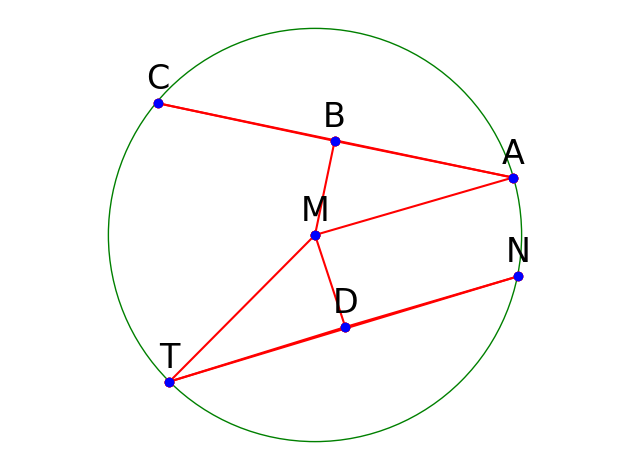

In [11]:
# Analyze the problem and create a Problem instance
problem = Problem(**problem_annotation)
# Plot the topological graph of the problem and save.
# The problem_topological_graph.png should be isomorphic to the problem_annotation.png.
problem.topological_graph.plot(save_path='example/problem_topological_graph.png')

In [12]:
# Create a Solver instance with the definitions and theorems files.
# Initialize the Solver based on the problem annotation.
definitions_file_path = '../symbolic_reasoner/definitions.txt'
theorem_file_path = '../symbolic_reasoner/theorems.txt'
solver = Solver(
    definitions_file_path=definitions_file_path,
    theorems_file_path=theorem_file_path,
    problem_data=problem_annotation
)

In [14]:
# Solve the problem with 2 iterations. The solution should be found
sol = solver.solve(max_depth=2, max_deduction_iteration=1, max_algebraic_reasoning_iteration=1)
if sol:
    print("Solution found")
    print("Solution:", sol)
else:
    print("No solution found")

Solution found
Solution: Equals(0.4886921906, MeasureOf(Angle(C, A, M)))


In [15]:
# Get the corresponding node in the proof graph and find the minimal proof subgraph for the solution.
sol_node = solver.proof_graph.find_node_by_predicate(sol)
minimal_proof = solver.proof_graph.find_minimal_subgraph_for_goal(sol_node)

In [16]:
from symbolic_reasoner.proof_graph_format import proof_graph_to_natural_language

In [17]:
# Minimal proof is a list of edges, we convert it to a sequence of natural language statements
proof_in_nl = proof_graph_to_natural_language(minimal_proof, goal_node=sol_node, prune=True) # Prune=True removes redundant conclusions
print(proof_in_nl)

Step 1:
Theorem: Known facts
Premises : start
Conclusions: ∠CAM, 3.14 = pi, BC ⊥ BM, ∠MNT, pi * (28 / 180) = ∠DTM, B on AC, C on ⊙(M, r_0), ⊙(M, r_0), DM ⊥ DN, D on NT, BM = DM, AB ⊥ BM, N on ⊙(M, r_0)

Step 2:
Theorem: Perpendicular to Right Angle
Premises : BC ⊥ BM
Conclusions: pi / 2 = ∠CBM

Step 3:
Theorem: Solve Linear Equation System
Premises : pi * (28 / 180) = ∠DTM, 3.14 = pi
Conclusions: 0.49 = ∠DTM

Step 4:
Theorem: Same Angle
Premises : B on AC, ∠CAM
Conclusions: ∠BAM = ∠CAM

Step 5:
Theorem: Point On Circle Def
Premises : C on ⊙(M, r_0)
Conclusions: r_0 = CM

Step 6:
Theorem: Perpendicular to Right Angle
Premises : DM ⊥ DN
Conclusions: pi / 2 = ∠NDM

Step 7:
Theorem: Same Angle
Premises : D on NT, ∠MNT
Conclusions: ∠MND = ∠MNT

Step 8:
Theorem: Circle Vertical Theorem
Premises : ⊙(M, r_0), DM ⊥ DN, D on NT
Conclusions: △DMN ≅ △DMT

Step 9:
Theorem: Circle Vertical Theorem
Premises : ⊙(M, r_0), B on AC, AB ⊥ BM
Conclusions: △ABM ≅ △CBM

Step 10:
Theorem: Point On Circle Def


More details about problem reasoning stage can be found in [symbolic_reasoner/demo.ipynb](../symbolic_reasoner/demo.ipynb)